In [2]:
!pip install transformers
!pip install evaluate
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
from PIL import Image
from evaluate import load
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AdamW, TrOCRProcessor, VisionEncoderDecoderModel

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv("/content/drive/MyDrive/IAM/gt.csv")

# split the data
train_df, test_df = train_test_split(df, test_size=0.15)

# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [7]:
# load metrics
cer_metric = load("cer")
def compute_cer(processor, pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return cer

In [8]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        image = Image.open(self.root_dir + "/" +file_name + ".png").convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding


In [9]:
# processer
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

# dataset creation
train_dataset = IAMDataset(root_dir='/content/drive/MyDrive/IAM/self_lines',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/drive/MyDrive/IAM/self_lines',
                           df=test_df,
                           processor=processor)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Number of training examples: 285
Number of validation examples: 51


In [10]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

# create dataoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

#model init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# train model
optimizer = AdamW(model.parameters(), lr=5e-5)
train_losses = []
test_losses = []
test_cer = []
for epoch in range(20):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    train_losses.append(train_loss/len(train_dataloader))
    print(f"Train Loss after epoch {epoch}:", train_loss/len(train_dataloader))

    # evaluate
    model.eval()
    valid_cer = 0.0
    with torch.no_grad():
        test_loss = 0.0
        for batch in tqdm(eval_dataloader):
            # get the inputs
            for k,v in batch.items():
                batch[k] = v.to(device)

            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))

            # calculate loss
            for k,v in batch.items():
              batch[k] = v.to(device)

            # forward + backward + optimize
            outputs_ = model(**batch)
            loss = outputs_.loss
            test_loss += loss.item()
            
            # compute metrics
            cer = compute_cer(processor, pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer

    test_losses.append(test_loss/len(eval_dataloader))
    test_cer.append(valid_cer / len(eval_dataloader))
    print(f"Test Loss after epoch {epoch}:", test_loss/len(eval_dataloader))
    print("Validation CER:", valid_cer / len(eval_dataloader))


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Train Loss after epoch 0: 2.6483707858456507


100%|██████████| 13/13 [00:25<00:00,  1.96s/it]


Test Loss after epoch 0: 3.3848319328748264
Validation CER: 0.5581672123077948


100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Train Loss after epoch 1: 1.809204152888722


100%|██████████| 13/13 [00:38<00:00,  2.99s/it]


Test Loss after epoch 1: 3.8456386969639706
Validation CER: 0.6498968827148276


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 2: 1.5351837939686246


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


Test Loss after epoch 2: 3.2330765632482676
Validation CER: 0.47004017411882226


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 3: 1.1576053429808881


100%|██████████| 13/13 [00:33<00:00,  2.55s/it]


Test Loss after epoch 3: 2.9092329190327573
Validation CER: 0.4368798865788479


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 4: 1.1640648175444868


100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


Test Loss after epoch 4: 3.2979472141999464
Validation CER: 0.4596749313249331


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 5: 1.0075176138844755


100%|██████████| 13/13 [00:39<00:00,  3.03s/it]


Test Loss after epoch 5: 3.3651799880541287
Validation CER: 0.5672314532454159


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 6: 0.9442698247730732


100%|██████████| 13/13 [00:35<00:00,  2.70s/it]


Test Loss after epoch 6: 2.9699067702660193
Validation CER: 0.4782857420054345


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 7: 0.6211502572728528


100%|██████████| 13/13 [00:30<00:00,  2.36s/it]


Test Loss after epoch 7: 3.035841799699343
Validation CER: 0.37361344349202147


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 8: 0.5709266973038515


100%|██████████| 13/13 [00:31<00:00,  2.44s/it]


Test Loss after epoch 8: 2.7557590145331163
Validation CER: 0.3869942564044603


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 9: 0.4944526215808259


100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


Test Loss after epoch 9: 2.5492794788800754
Validation CER: 0.3384916340214851


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 10: 0.3895959996928771


100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


Test Loss after epoch 10: 2.8568160350506124
Validation CER: 0.3432248229163383


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 11: 0.44528718541065854


100%|██████████| 13/13 [00:31<00:00,  2.40s/it]


Test Loss after epoch 11: 2.9693845143684974
Validation CER: 0.388752971805185


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 12: 0.8275614298052258


100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


Test Loss after epoch 12: 3.195660957923302
Validation CER: 0.4705114073784478


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 13: 0.8542580045759678


100%|██████████| 13/13 [00:31<00:00,  2.43s/it]


Test Loss after epoch 13: 3.212328709088839
Validation CER: 0.43152398300338457


100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Train Loss after epoch 14: 0.831223776564002


100%|██████████| 13/13 [00:26<00:00,  2.03s/it]


Test Loss after epoch 14: 3.4054424395928016
Validation CER: 0.45349048882646426


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 15: 0.6335395384165976


100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


Test Loss after epoch 15: 3.2209573800747213
Validation CER: 0.4050061376935563


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 16: 0.8537765844828553


100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Test Loss after epoch 16: 3.231951438463651
Validation CER: 0.4399971029573522


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 17: 0.505822891369462


100%|██████████| 13/13 [00:35<00:00,  2.74s/it]


Test Loss after epoch 17: 3.108272914703076
Validation CER: 0.43825892007400913


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 18: 0.4152180130283038


100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


Test Loss after epoch 18: 3.207615641447214
Validation CER: 0.3788926891145341


100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


Train Loss after epoch 19: 0.3715047567254967


100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Test Loss after epoch 19: 3.05941248857058
Validation CER: 0.420396619006574


In [15]:
model.save_pretrained("/content/drive/MyDrive/troce_model/")

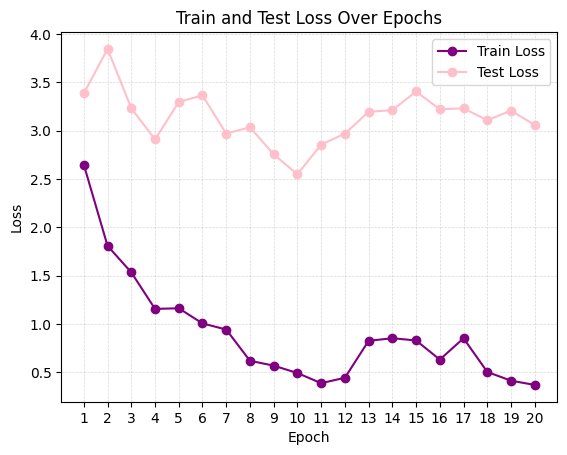

In [29]:
import matplotlib.pyplot as plt

# Create a list of epoch numbers (e.g., 1, 2, 3, ..., 20)
epochs = list(range(1, len(test_losses) + 1))

# Plot train loss
plt.plot(epochs, train_losses, label='Train Loss', marker='o', linestyle='-', color="purple")

# Plot test loss
plt.plot(epochs, test_losses, label='Test Loss', marker='o', linestyle='-',  color='pink')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()

# Show the plot
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.show()

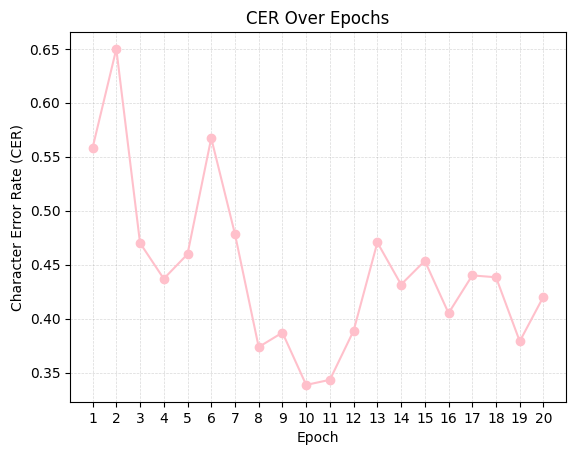

In [30]:
import numpy as np
import matplotlib.pyplot as plt
# Create a list of epochs (or x-values)
epochs = list(range(1, len(test_cer) + 1))

# Plot the CER values
plt.plot(epochs, test_cer, marker='o', linestyle='-',  color='pink')

plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Character Error Rate (CER)')
plt.title('CER Over Epochs')

# Show the plot
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.show()
